In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/CKD_split/train',
    target_size=(256, 256),
    batch_size=32
)

val_data = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/CKD_split/val',
    target_size=(256, 256),
    batch_size=32
)

test_data = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/CKD_split/test',
    target_size=(256, 256),
    batch_size=32
)

num_classes = train_data.num_classes
nb_train_samples = train_data.samples
nb_val_samples = val_data.samples

Found 1400 images belonging to 4 classes.
Found 300 images belonging to 4 classes.
Found 300 images belonging to 4 classes.


In [ ]:
def Resnet50_model_finetuning(freeze_baselayers):
    base_model = tf.keras.applications.resnet50.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=(256, 256, 3),
        classes=5  # Change this to the number of classes in your dataset
    )

    # Freeze base model layers if specified
    if freeze_baselayers:
        base_model.trainable = False

    # Building the new classification layers on top of the base model
    input = base_model.inputs
    mod = base_model.output
    mod = tf.keras.layers.Flatten()(mod)
    mod = Dense(64, activation="relu")(mod)
    mod = Dense(64, activation="relu")(mod)
    output = Dense(num_classes, activation='softmax')(mod)

    # Creating the new model
    new_model = tf.keras.Model(inputs=input, outputs=output)
    return new_model

In [ ]:
model = Resnet50_model_finetuning(freeze_baselayers=True)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_data, epochs=10, validation_data=val_data)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 324s 7s/step - accuracy: 0.3407 - loss: 5.1208 - val_accuracy: 0.6967 - val_loss: 0.7276
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 351s 8s/step - accuracy: 0.6550 - loss: 0.8367 - val_accuracy: 0.8533 - val_loss: 0.4923
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 326s 7s/step - accuracy: 0.7290 - loss: 0.7456 - val_accuracy: 0.7900 - val_loss: 0.5766
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 314s 7s/step - accuracy: 0.8072 - loss: 0.5287 - val_accuracy: 0.8200 - val_loss: 0.4106
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step - accuracy: 0.8601 - loss: 0.3707 - val_accuracy: 0.7633 - val_loss: 0.4770
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 323s 7s/step - accuracy: 0.8803 - loss: 0.3169 - val_accuracy: 0.8533 - val_loss: 0.2876
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 322s 7s/step - accuracy: 0.8730 - loss: 0.3484 - val_accuracy: 0.8633 - val_loss: 0.5967
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step - accuracy: 0.8097 - loss: 0.5539 - val_accuracy: 0.7733 - v

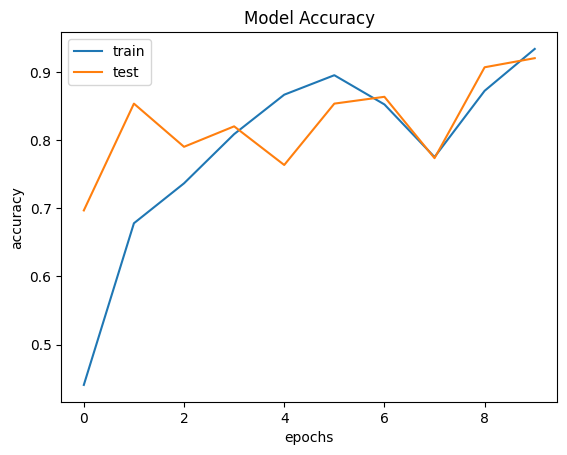

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "test"], loc="upper left")
plt.show()

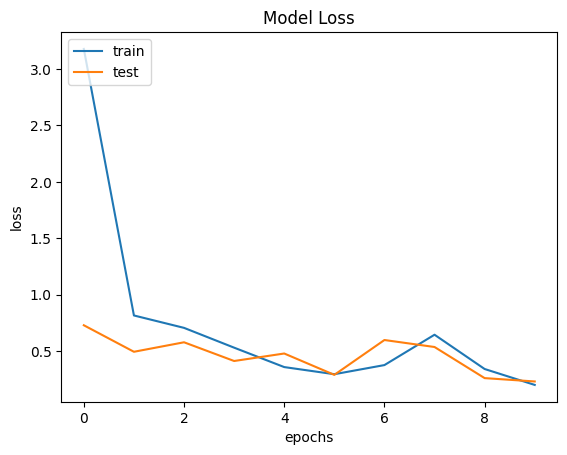

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
results = model.evaluate(test_data, verbose=0)
print("Loss: {:.5f}".format(results[0]))
print("Accuracy: {:.2f}%".format(results[1] * 100))

Loss: 0.22407
Accuracy: 92.00%


In [ ]:
import os
import shutil
import random

# SOURCE DATASET PATH
source_dir = '/content/drive/MyDrive/CKDupdated'

# DESTINATION PATH
base_dir = '/content/drive/MyDrive/CKD_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create directories
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Loop through each class
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total_images = len(images)
    train_end = int(train_ratio * total_images)
    val_end = train_end + int(val_ratio * total_images)

    splits = {
        train_dir: images[:train_end],
        val_dir: images[train_end:val_end],
        test_dir: images[val_end:]
    }

    for split_dir, split_images in splits.items():
        class_split_dir = os.path.join(split_dir, class_name)
        os.makedirs(class_split_dir, exist_ok=True)

        for img in split_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(class_split_dir, img)
            shutil.copy(src, dst)

print("✅ Dataset successfully split into Train / Val / Test")


✅ Dataset successfully split into Train / Val / Test
